In [132]:
import warnings
warnings.filterwarnings('ignore')

In [133]:
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import numpy as np
import pandas as pd
import pandahouse as ph

In [134]:
import orbit
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components

In [135]:
from orbit.utils.params_tuning import grid_search_orbit
from orbit.diagnostics.backtest import BackTester

#### Выбираем метрику DAU

В качестве метрики для предсказания выберем DAU. Именно в ней хорошо наблюдалось влияние событий, произошедших за последние время, в том числе влияние рекламной компании и сбоев. Также эта метрика является стандартной для оценки активности пользователей в приложениях.

In [218]:
#DAU
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20250520',
'user':'student',
'password':'dpo_python_2020'
}

q = """
SELECT toDate(time) AS day,
       count(DISTINCT user_id) AS users
  FROM simulator_20250520.feed_actions
 WHERE toDate(time) <= today()-1
 GROUP BY day
"""
DAU = ph.read_clickhouse(q, connection=connection)

<Axes: >

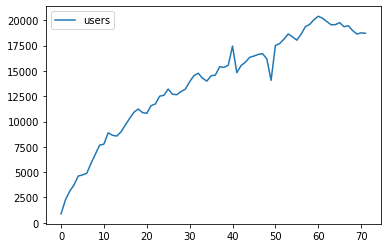

In [219]:
sns.lineplot(DAU)

In [142]:
# Добавляем три регрессора, когда проводилась рекламная компания
# И когда был сбой, а также флешмоб
ad_campain = '2025-05-15'
outage = '2025-05-24'

Пока будут добавлены три известных события из исторических данных - рекламная компания, сбой, а также флешмоб. Для future_df можно будет добавить информацию о будущих рекламных компаниях для лучшей предсказательности модели. Здесь же будет предполагаться, что рекламных компаний и сбоев в будущем не было, то есть будущие значения будут нулями.

In [220]:
DAU['is_ad_campaign'] = (
    DAU['day'] == pd.to_datetime(ad_campain)).astype('int')

In [221]:
DAU['is_outage'] = (
    DAU['day'] == pd.to_datetime(outage)).astype('int')

In [222]:
DAU['is_flashmob'] = (
    (DAU['day'] >= '2025-05-16') & (DAU['day'] <= '2025-05-22')).astype(int)

#### Строим модель в Orbit

In [224]:
# Определяем сетку параметров
param_grid = {
    'global_trend_option': ['logistic', 'loglinear'],
    'n_bootstrap_draws': [100, 1000]
}

In [225]:
DAU.day.max()-DAU.day.min()

Timedelta('71 days 00:00:00')

Для минимальной тренировочной выборки в 50, который составляет 70% от общей выборки максимальный горизонт теста для минимального 2-фолд теста составляет 16,при выборе шага в 5 дней, что не является достаточным для валидирования горизонта теста в 1 месяц, а только на половину месяца. Для шага только в 1 день, максимальный горизонт для 2-фолд теста также будет только 20 дней и не покрывает потребностей в 30 дней. Возьмем горизонт только на полмесяца, и проведем 2-фолд валидацию
* Фолд1: обучение 1-50, тест на 51-66
* Фолд2: обучение 1-55, тест на 56-71

In [226]:
# Конфигурация BackTester
bt_config = {
    'min_train_len': 50,  # Минимальная длина обучающей выборки
    'incremental_len': 5, # Шаг теста
    'forecast_len': 16   # Горизонт теста
}

In [227]:
dlt = DLT(
    response_col='users',
    date_col='day',
    regressor_col=['is_ad_campaign', 'is_outage', 'is_flashmob'],
    seasonality=None,
    estimator='stan-mcmc',
    regressor_sign=['+', '-', '+']  # Реклама и флешмоб увеличивают метрику
                                    # Cбой уменьшает
)

In [228]:
# Запуск grid_search_orbit
search_results = grid_search_orbit(
    param_grid=param_grid,
    model=dlt,
    df=DAU,
    **bt_config,
    metrics=None, 
    verbose=True
)

  0%|          | 0/4 [00:00<?, ?it/s]

2025-06-16 14:57:55 - orbit - INFO - tuning hyper-params {'global_trend_option': 'logistic', 'n_bootstrap_draws': 100}
INFO:orbit:tuning hyper-params {'global_trend_option': 'logistic', 'n_bootstrap_draws': 100}
2025-06-16 14:57:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-06-16 14:57:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-06-16 14:57:56 - orbit - INFO - tuning metric:0.24279
INFO:orbit:tuning metric:0.24279
2025-06-16 14:57:56 - orbit - INFO - tuning hyper-params {'global_trend_option': 'logistic', 'n_bootstrap_draws': 1000}
INFO:orbit:tuning hyper-params {'global_trend_option': 'logistic', 'n_bootstrap_draws': 1000}
2025-06-16 14:57:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-06-16 14:57:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-06-16 14:57:57 - orbit - INFO - tuning metric:0.24116
INFO:orbit:tuning metric:0.24116
2025-06-16 14:57:57 - orbit - INFO - tuning hyper-params {'global_trend_option': 'loglinear', 'n_bootstrap_draws': 100}
INFO:orbit:tuning hyper-params {'global_trend_option': 'loglinear', 'n_bootstrap_draws': 100}
2025-06-16 14:57:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-06-16 14:57:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-06-16 14:58:01 - orbit - INFO - tuning metric:0.17356
INFO:orbit:tuning metric:0.17356
2025-06-16 14:58:01 - orbit - INFO - tuning hyper-params {'global_trend_option': 'loglinear', 'n_bootstrap_draws': 1000}
INFO:orbit:tuning hyper-params {'global_trend_option': 'loglinear', 'n_bootstrap_draws': 1000}
2025-06-16 14:58:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-06-16 14:58:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-06-16 14:58:05 - orbit - INFO - tuning metric:0.17116
INFO:orbit:tuning metric:0.17116


In [229]:
best_params = search_results[0][0]
print("Лучшие параметры:", best_params)

Лучшие параметры: {'global_trend_option': 'loglinear', 'n_bootstrap_draws': 1000}


In [230]:
# Обучение модели с лучшими параметрами 
dlt = DLT(
    response_col='users',
    date_col='day',
    regressor_col=['is_ad_campaign', 'is_outage', 'is_flashmob'],
    seasonality=None,
    estimator='stan-mcmc',
    regressor_sign=['+', '-', '+'],
    **best_params
)

In [231]:
dlt.fit(df=DAU)

2025-06-16 14:58:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [232]:
# Валидация модели с BackTester
bt = BackTester(
    model=dlt,
    df=DAU,
    min_train_len=50,
    incremental_len=5,
    forecast_len=16
)
bt.fit_predict()


2025-06-16 14:59:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-06-16 14:59:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [233]:
metrics = bt.score() 
print("Результаты бэктестинга:", metrics)

Результаты бэктестинга:   metric_name  metric_values  is_training_metric
0       smape   1.732624e-01               False
1       wmape   1.511365e-01               False
2        mape   1.510001e-01               False
3         mse   1.444656e+07               False
4         mae   2.908017e+03               False
5       rmsse   7.802940e+00               False


In [234]:
print("Коэффициенты регрессоров:")
print(dlt.get_regression_coefs())

Коэффициенты регрессоров:
        regressor regressor_sign  coefficient  coefficient_lower  \
0  is_ad_campaign       Positive     0.734810           0.092243   
1     is_flashmob       Positive     0.696073           0.039847   
2       is_outage       Negative    -0.689492          -1.721543   

   coefficient_upper  Pr(coef >= 0)  Pr(coef < 0)  
0           2.248848            1.0           0.0  
1           1.676671            1.0           0.0  
2          -0.145392            0.0           1.0  


In [235]:
pd.to_datetime('2025-06-16') + pd.to_timedelta(15, 'D')

Timestamp('2025-07-01 00:00:00')

In [236]:
# Базовый сценарий: без кампаний и сбоев
future_df = pd.DataFrame({
    'day': pd.date_range(start='2025-06-16', end='2025-07-01', freq='D'),  # 16 дней
    'is_ad_campaign': 0,
    'is_outage': 0,
    'is_flashmob':0
})

In [238]:
future_df.head()

,day,is_ad_campaign,is_outage,is_flashmob
0,2025-06-16,0,0,0
1,2025-06-17,0,0,0
2,2025-06-18,0,0,0
3,2025-06-19,0,0,0
4,2025-06-20,0,0,0


In [239]:
pred = dlt.predict(df=future_df)

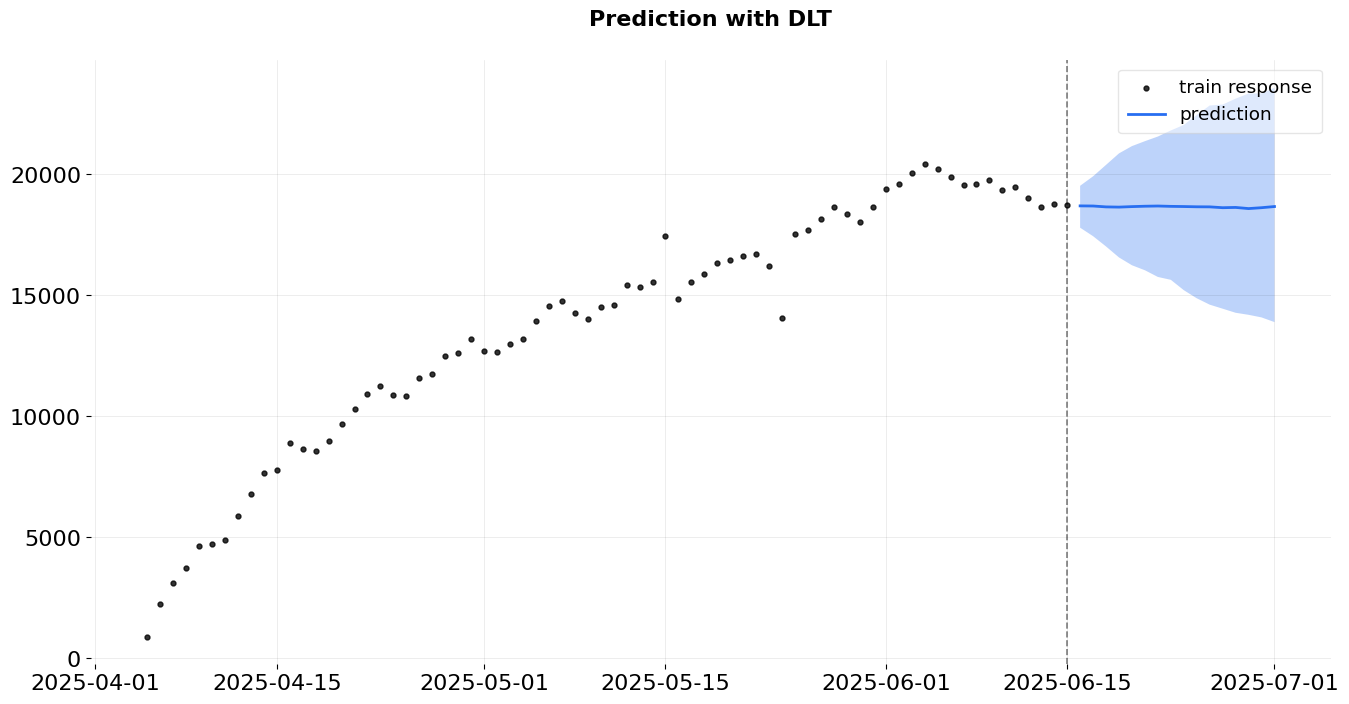

In [240]:
# Используем plot_predicted_data с историческими данными и прогнозом
_ = plot_predicted_data(
    DAU,     
    pred,         # DataFrame с предсказаниями
    "day",           # Колонка с датами
    'users',          # Колонка с фактическими значениями
    title='Prediction with DLT'  # Заголовок графика
)

## Вывод

Конечная модель предсказывает, все возможные исходы, дальнейший рост, а также дальнейшие падание активности, если приложение продолжит плохо работать. Среднее же значение выходит на плато. Данная модель мне кажется наиболее удачной, потому что опирается на все известные случаи резкого всплеска и падения пользователей в качестве регрессоров, а также на общий тренд самой метрики. В качестве модификации в любой момент можно скорректировать предсказания изменив значения будущих регрессоров - например, если мы знаем в какие дни будет проводиться рекламная компания или технические работы.
